# 4 Data preprocessing - features selection

<b> Purpose of the action </b> - choose the best features for different types of models using the perturbation technique:
- Fit model on training data
- Iteratively shuffle one function at a time
- Check model accuracy and log loss on new dataset
- Remove features if accuracy is improved and log loss is decreased

<b> </b>
<b> Action plan </b>:
- Perform features selection for different types of tree-based models:
    - RandomForestClassifier
    - AdaBoostClassifier
    - XGBClassifier
    - CatBoostClassifier
- Perform features selection for different types of linear and other models:
    - LogisticRegression
    - LinearSVC
    - SVC with RBF
    - KNeighborsClassifier
- Show features importances for all type of models
- Show difference in accuracy and log loss after shuffling each features for each models
- Compare accuracy and log loss for all models fitting on whole and reduced data sets. Sometimes the drop in accuracy is not bad, diversity is more important for future ensembling models 
- Save all reduced data sets

## 4.0 Import necessary libraries and modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from data_preprocessing import plot_feature_importances, feature_reduction

##  4.1 Features selection for tree-based models

### 4.1.1 Read datasets dedicated for tree-based models

In [6]:
train_set = pd.read_csv("./preprocessed_data/processed_base_train_set.csv", index_col=0)
validation_set = pd.read_csv("./preprocessed_data/processed_base_validation_set.csv", index_col=0)
test_set = pd.read_csv("./preprocessed_data/processed_base_test_set.csv", index_col=0)

In [7]:
train_set.head()

,FTR,HomeTeamWinStreak3,HomeTeamWinStreak5,HomeTeamLossStreak3,HomeTeamLossStreak5,AwayTeamWinStreak3,AwayTeamWinStreak5,AwayTeamLossStreak3,AwayTeamLossStreak5,IsHomeTeamRegulars,...,HomeTeamGoalsLost,AwayTeamGoalsLost,HomeTeamShootsMade,AwayTeamShootsMade,HomeTeamTargetShootsMade,AwayTeamTargetShootsMade,HomeTeamCorners,AwayTeamCorners,HomeTeamTotalPoints,AwayTeamTotalPoints
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058824,0.094118,0.046296,0.030864,0.039414,0.022523,0.061017,0.033898,0.082474,0.051546
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.129412,0.070588,0.034722,0.038580,0.028153,0.028153,0.091525,0.067797,0.051546,0.103093
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.094118,0.035294,0.023148,0.065586,0.022523,0.050676,0.074576,0.064407,0.072165,0.113402
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058824,0.094118,0.042438,0.046296,0.033784,0.039414,0.091525,0.047458,0.072165,0.041237
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.105882,0.047059,0.050154,0.038580,0.050676,0.039414,0.111864,0.064407,0.030928,0.103093


### 4.1.2 Split datasets to feature and label sets

In [8]:
X_train, y_train = train_set.drop(columns='FTR'), train_set['FTR']
X_valid, y_valid = validation_set.drop(columns='FTR'), validation_set['FTR']
X_test, y_test = test_set.drop(columns='FTR'), test_set['FTR']

### 4.1.3 Perform features selection for CatBoostClassifier model using perturbation technique

#### 4.1.3.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [9]:
clf = CatBoostClassifier(random_state=42, n_estimators=400, max_depth=9, verbose=0)
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for CatBoostClassifier
Accuracy score on train set: 1.0
Accuracy score on valid set: 0.74
Base log loss result on train set: 0.06
Base log loss result on valid set: 9.11


#### 4.1.3.2 Check feature importance for this model

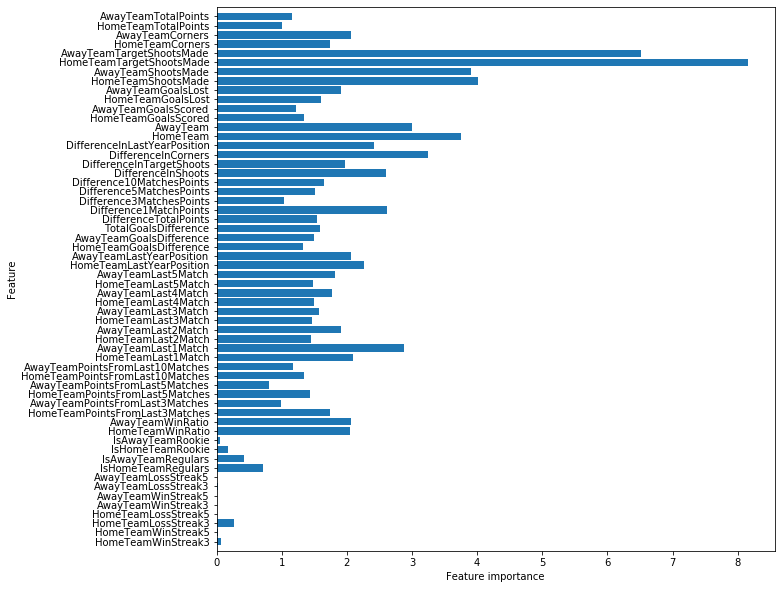

Number of features before reduction: 58


In [10]:
plt.figure(figsize=(10, 10))
plot_feature_importances(clf, X_train.columns)
plt.show()
print('Number of features before reduction:', len(X_train.columns))

#### 4.1.3.3 Reduce number of features using perturbation technique

In [11]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'HomeTeamWinRatio', 'AwayTeamWinRatio', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference', 'AwayTeamGoalsDifference', 'TotalGoalsDifference', 'DifferenceTotalPoints', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'Difference5MatchesPoints', 'Difference10MatchesPoints', 'DifferenceInShoots', 'DifferenceInTargetShoots', 'DifferenceInCorners', 'DifferenceInLastYearPosition', 'HomeTeam', 'AwayTeam', 'HomeTeamGoalsScored', 'A

#### 4.1.3.4 Show difference in accuracy and log loss after shuffling each features

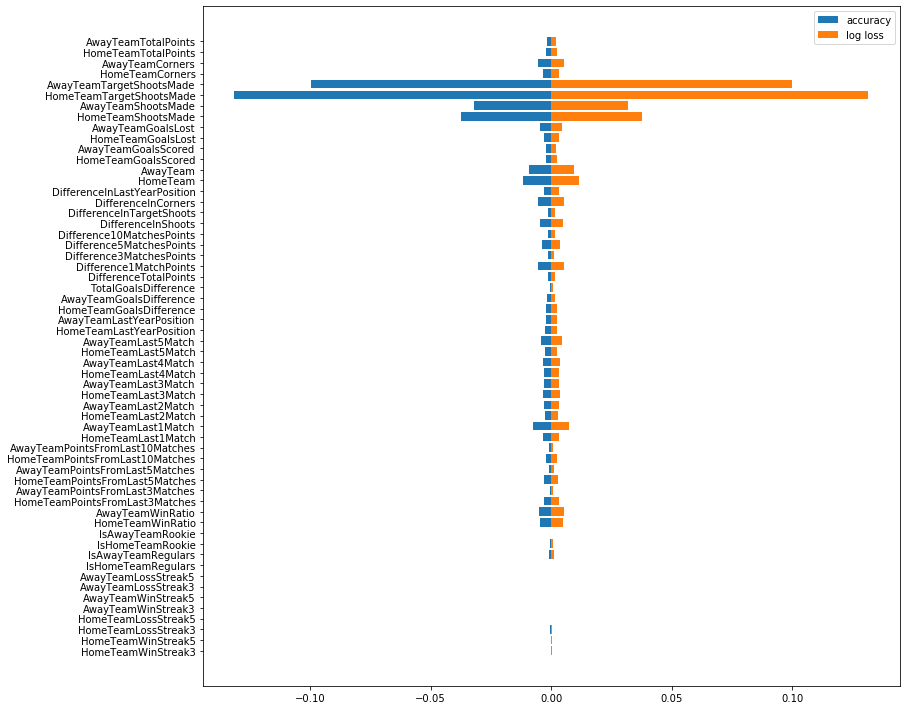

In [12]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.1.3.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [13]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

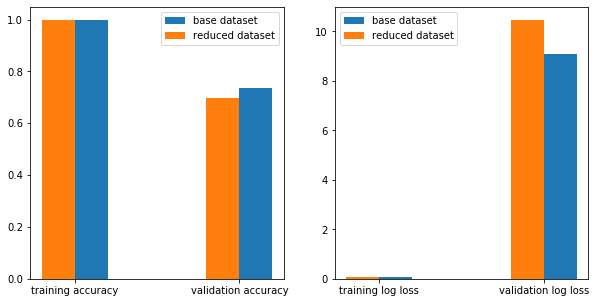

In [14]:
# fit new model on reduced dataset
clf = CatBoostClassifier(random_state=42, n_estimators=400, max_depth=9, verbose=0)
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.1.3.6 Save reduced dataset

In [15]:
# concat reduced feature sets with labels
train_set_catboost = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_catboost = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_catboost = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_catboost.to_csv("./preprocessed_data/processed_train_set_catboost.csv")
valid_set_catboost.to_csv("./preprocessed_data/processed_validation_set_catboost.csv")
test_set_catboost.to_csv("./preprocessed_data/processed_test_set_catboost.csv")

### 4.1.4 Perform features selection for RandomForestClassifier model using perturbation technique

#### 4.1.4.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [16]:
clf = RandomForestClassifier(random_state=42, n_estimators=600, max_depth=19, verbose=0) 
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for RandomForestClassifier
Accuracy score on train set: 1.0
Accuracy score on valid set: 0.68
Base log loss result on train set: 0.0
Base log loss result on valid set: 11.2


#### 4.1.4.2 Check feature importance for this model

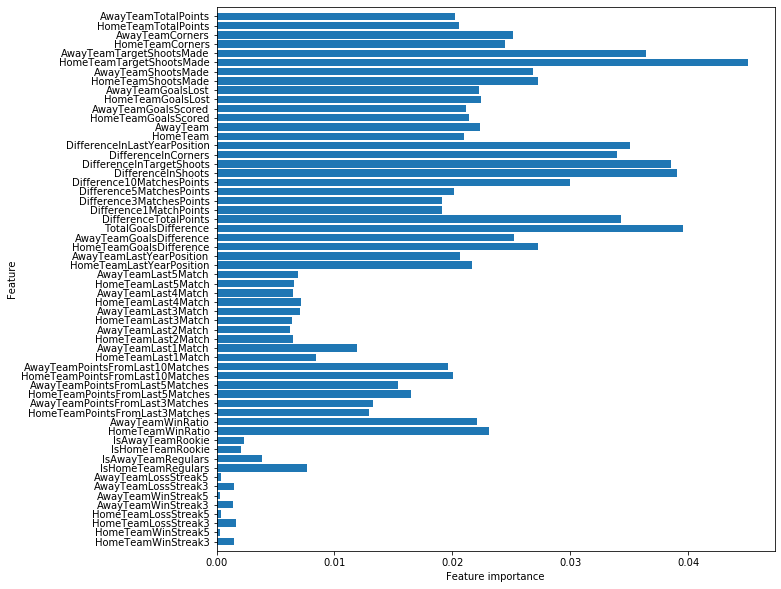

Number of features before reduction: 58


In [17]:
plt.figure(figsize=(10, 10))
plot_feature_importances(clf, X_train.columns)
plt.show()
print('Number of features before reduction:', len(X_train.columns))

#### 4.1.4.3 Reduce number of features using perturbation technique

In [18]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinRatio', 'AwayTeamWinRatio', 'AwayTeamLast1Match', 'Difference1MatchPoints', 'DifferenceInShoots', 'DifferenceInTargetShoots', 'DifferenceInCorners', 'DifferenceInLastYearPosition', 'AwayTeam', 'AwayTeamShootsMade', 'HomeTeamTargetShootsMade', 'AwayTeamTargetShootsMade']
Number of features after reduction: 12


#### 4.1.4.4 Show difference in accuracy and log loss after shuffling each features

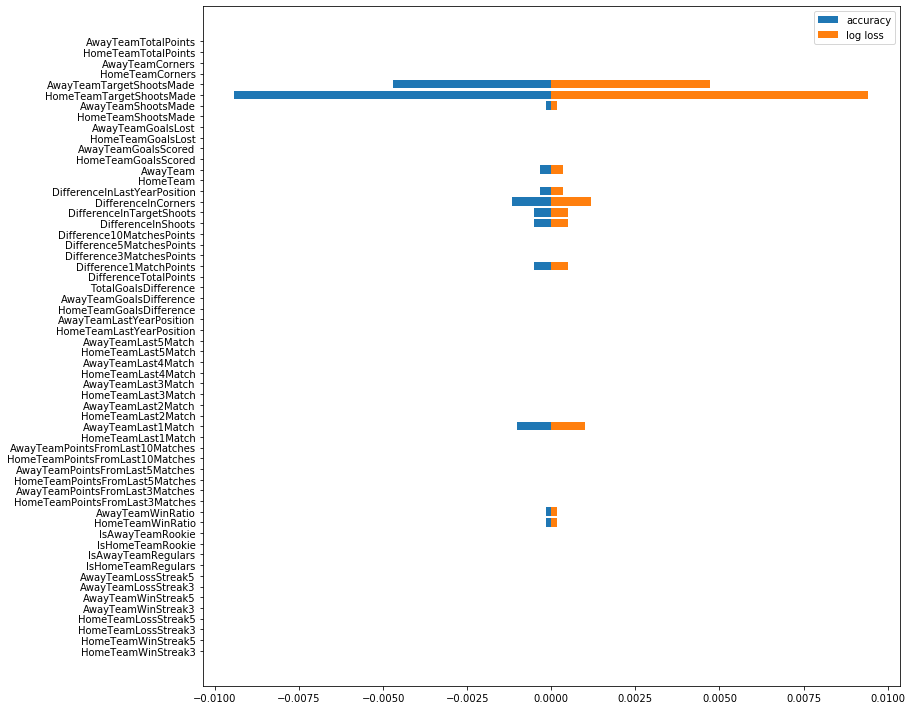

In [19]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.1.4.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [20]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

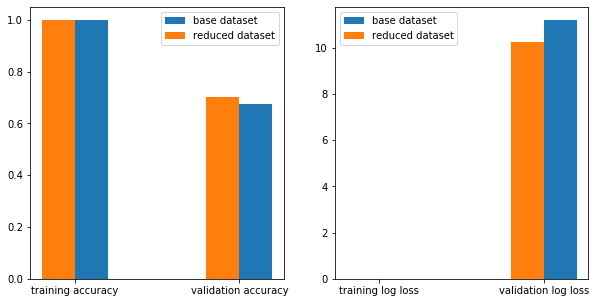

In [21]:
# fit new model on reduced dataset
clf = RandomForestClassifier(random_state=42, n_estimators=600, max_depth=19, verbose=0) 
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.1.4.6 Save reduced dataset

In [22]:
# concat reduced feature sets with labels
train_set_randomforest = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_randomforest = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_randomforest = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_randomforest.to_csv("./preprocessed_data/processed_train_set_randomforest.csv")
valid_set_randomforest.to_csv("./preprocessed_data/processed_validation_set_randomforest.csv")
test_set_randomforest.to_csv("./preprocessed_data/processed_test_set_randomforest.csv")

### 4.1.5 Perform features selection for XGBClassifier model using perturbation technique

#### 4.1.5.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [23]:
clf = XGBClassifier(subsample=0.8, 
                    scale_pos_weight=0.8,
                    reg_alpha=1e-05,
                    n_estimators=700,
                    min_child_weight=3,
                    max_depth=8,
                    learning_rate=0.01,
                    gamma=0.4,
                    colsample_bytree=0.7,
                    random_state=42,
                    verbose=0)
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for XGBClassifier
Accuracy score on train set: 0.95
Accuracy score on valid set: 0.72
Base log loss result on train set: 1.58
Base log loss result on valid set: 9.63


#### 4.1.5.2 Check feature importance for this model

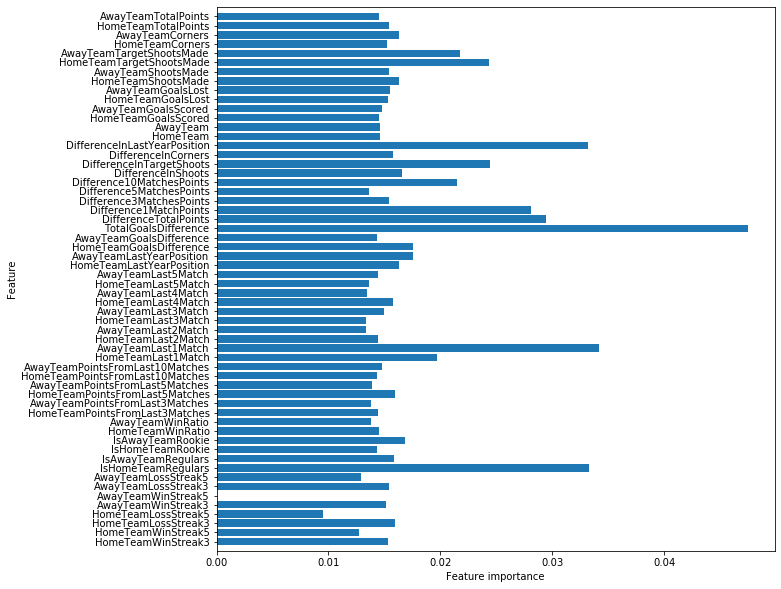

Number of features before reduction: 58


In [24]:
plt.figure(figsize=(10, 10))
plot_feature_importances(clf, X_train.columns)
plt.show()
print('Number of features before reduction:', len(X_train.columns))

#### 4.1.5.3 Reduce number of features using perturbation technique

In [25]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamLossStreak3', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'HomeTeamWinRatio', 'AwayTeamWinRatio', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference', 'AwayTeamGoalsDifference', 'TotalGoalsDifference', 'DifferenceTotalPoints', 'Difference1MatchPoints', 'Difference3MatchesPoints', 'Difference5MatchesPoints', 'Difference10MatchesPoints', 'DifferenceInShoots', 'DifferenceInTargetShoots', 'DifferenceInCorners', 'DifferenceIn

#### 4.1.5.4 Show difference in accuracy and log loss after shuffling each features

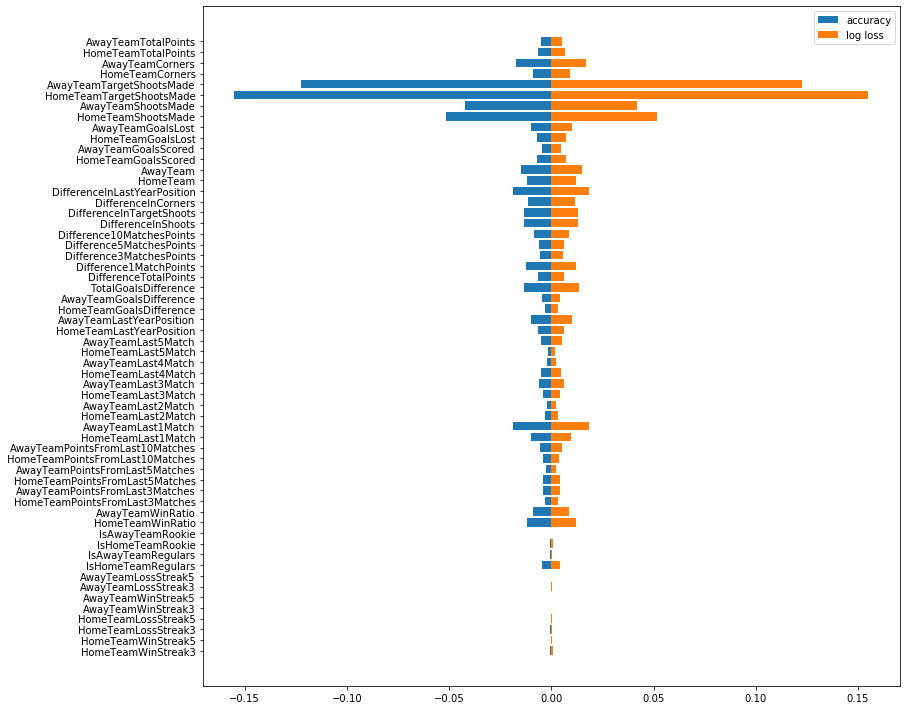

In [26]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.1.5.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [27]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

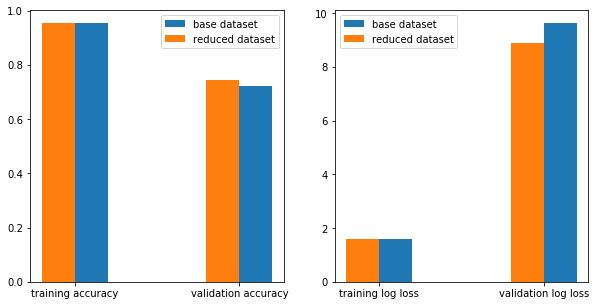

In [28]:
# fit new model on reduced dataset
clf = XGBClassifier(subsample=0.8, 
                    scale_pos_weight=0.8,
                    reg_alpha=1e-05,
                    n_estimators=700,
                    min_child_weight=3,
                    max_depth=8,
                    learning_rate=0.01,
                    gamma=0.4,
                    colsample_bytree=0.7,
                    random_state=42,
                    verbose=0)
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.1.5.6 Save reduced dataset

In [29]:
# concat reduced feature sets with labels
train_set_xgb = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_xgb = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_xgb = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_xgb.to_csv("./preprocessed_data/processed_train_set_xgbboost.csv")
valid_set_xgb.to_csv("./preprocessed_data/processed_validation_set_xgbboost.csv")
test_set_xgb.to_csv("./preprocessed_data/processed_test_set_xgbboost.csv")

### 4.1.6 Perform features selection for AdaBoostClassifier model using perturbation technique

#### 4.1.6.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [31]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                         n_estimators=30,
                         learning_rate=0.6,
                         random_state=42)
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for AdaBoostClassifier
Accuracy score on train set: 0.69
Accuracy score on valid set: 0.69
Base log loss result on train set: 10.81
Base log loss result on valid set: 10.68


#### 4.1.6.2 Check feature importance for this model

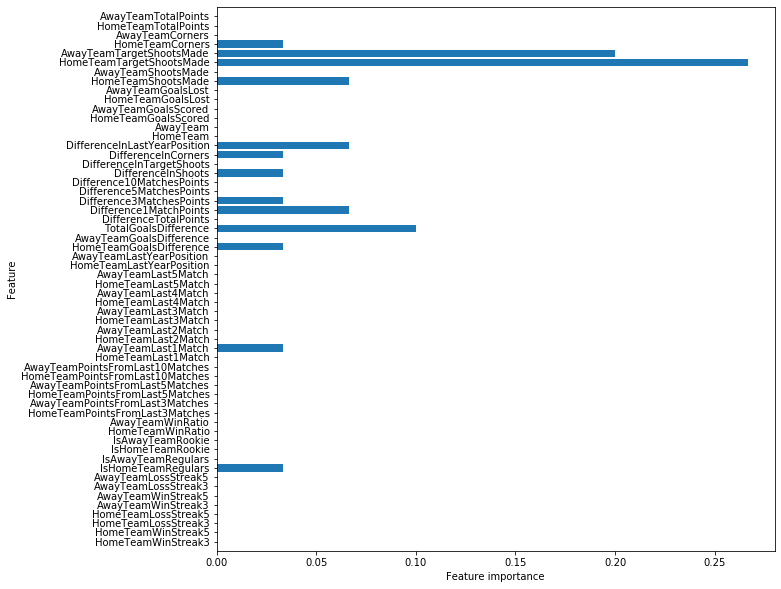

Number of features before reduction: 58


In [32]:
plt.figure(figsize=(10, 10))
plot_feature_importances(clf, X_train.columns)
plt.show()
print('Number of features before reduction:', len(X_train.columns))

#### 4.1.6.3 Reduce number of features using perturbation technique

In [33]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['IsHomeTeamRegulars', 'AwayTeamLast1Match', 'TotalGoalsDifference', 'Difference1MatchPoints', 'DifferenceInShoots', 'DifferenceInCorners', 'DifferenceInLastYearPosition', 'HomeTeamShootsMade', 'HomeTeamTargetShootsMade', 'AwayTeamTargetShootsMade', 'HomeTeamCorners']
Number of features after reduction: 11


#### 4.1.6.4 Show difference in accuracy and log loss after shuffling each features

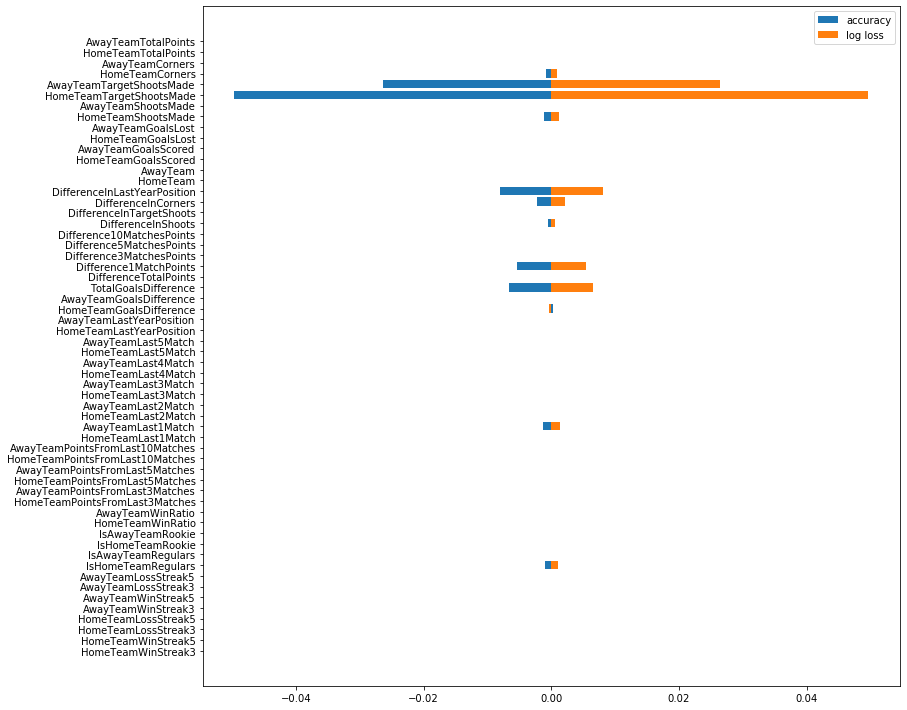

In [34]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.1.6.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [35]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

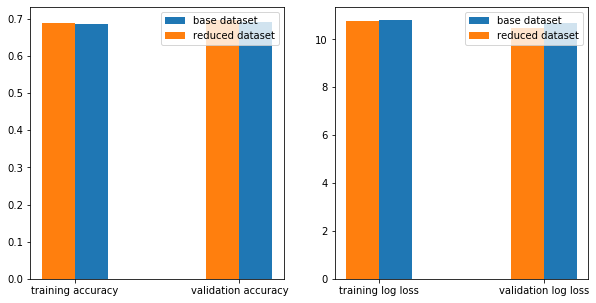

In [36]:
# fit new model on reduced dataset
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                         n_estimators=30,
                         learning_rate=0.6,
                         random_state=42)
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.1.6.6 Save reduced dataset

In [37]:
# concat reduced feature sets with labels
train_set_adaboost = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_adaboost = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_adaboost = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_adaboost.to_csv("./preprocessed_data/processed_train_set_adaboost.csv")
valid_set_adaboost.to_csv("./preprocessed_data/processed_validation_set_adaboost.csv")
test_set_adaboost.to_csv("./preprocessed_data/processed_test_set_adaboost.csv")

###  4.2 Features selection for linear and others models (Knn, Kernel's models)

### 4.2.1 Read datasets for linear models

In [38]:
train_set = pd.read_csv("./preprocessed_data/processed_categorical_train_set.csv", index_col=0)
validation_set = pd.read_csv("./preprocessed_data/processed_categorical_validation_set.csv", index_col=0)
test_set = pd.read_csv("./preprocessed_data/processed_categorical_test_set.csv", index_col=0)

In [39]:
train_set.head()

,FTR,HomeTeam,AwayTeam,HomeTeamWinStreak3,HomeTeamWinStreak5,HomeTeamLossStreak3,HomeTeamLossStreak5,AwayTeamWinStreak3,AwayTeamWinStreak5,AwayTeamLossStreak3,...,HomeTeamGoalsScored_Cat,AwayTeamGoalsScored_Cat,HomeTeamGoalsLost_Cat,AwayTeamGoalsLost_Cat,HomeTeamShootsMade_Cat,AwayTeamShootsMade_Cat,HomeTeamCorners_Cat,AwayTeamCorners_Cat,HomeTeamTotalPoints_Cat,AwayTeamTotalPoints_Cat
0,1.0,0.357957,0.619342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1.0,0.433244,0.410104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.111111
2,0.0,0.539812,0.231118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111
3,0.0,0.432336,0.493687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1.0,0.423431,0.527671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111


### 4.2.2 Split datasets to feature and label sets

In [40]:
X_train, y_train = train_set.drop(columns='FTR'), train_set['FTR']
X_valid, y_valid = validation_set.drop(columns='FTR'), validation_set['FTR']
X_test, y_test = test_set.drop(columns='FTR'), test_set['FTR']

### 4.2.3 Perform feature reduction for LinearSVC model using perturbation technique

#### 4.2.3.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [42]:
clf = SVC(kernel='linear', C=0.1, probability=True, random_state=42, verbose=0)
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for SVC
Accuracy score on train set: 0.68
Accuracy score on valid set: 0.67
Base log loss result on train set: 11.08
Base log loss result on valid set: 11.3


#### 4.2.3.2 Check feature importance for this model

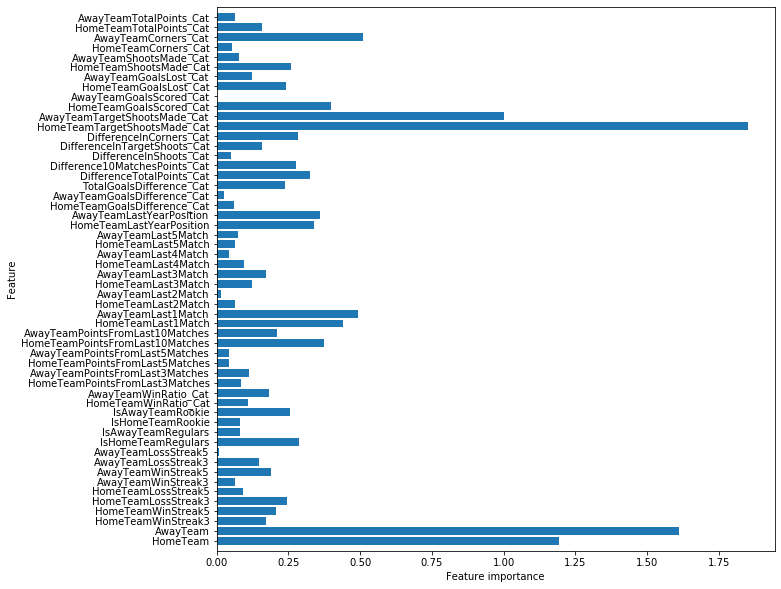

Number of features before reduction: 54


In [43]:
plt.figure(figsize=(10, 10))
plot_feature_importances(clf, X_train.columns)
plt.show()
print('Number of features before reduction:', len(X_train.columns))

#### 4.2.3.3 Reduce number of features using perturbation technique

In [44]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'AwayTeamWinStreak3', 'AwayTeamWinStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsAwayTeamRookie', 'HomeTeamWinRatio_Cat', 'HomeTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast3Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast3Match', 'HomeTeamLastYearPosition', 'TotalGoalsDifference_Cat', 'DifferenceTotalPoints_Cat', 'DifferenceInShoots_Cat', 'DifferenceInTargetShoots_Cat', 'DifferenceInCorners_Cat', 'HomeTeamTargetShootsMade_Cat', 'AwayTeamTargetShootsMade_Cat', 'HomeTeamGoalsLost_Cat', 'AwayTeamShootsMade_Cat', 'HomeTeamCorners_Cat', 'HomeTeamTotalPoints_Cat', 'AwayTeamTotalPoints_Cat']
Number of features after reduction: 31


#### 4.2.3.4 Show difference in accuracy and log loss after shuffling each features

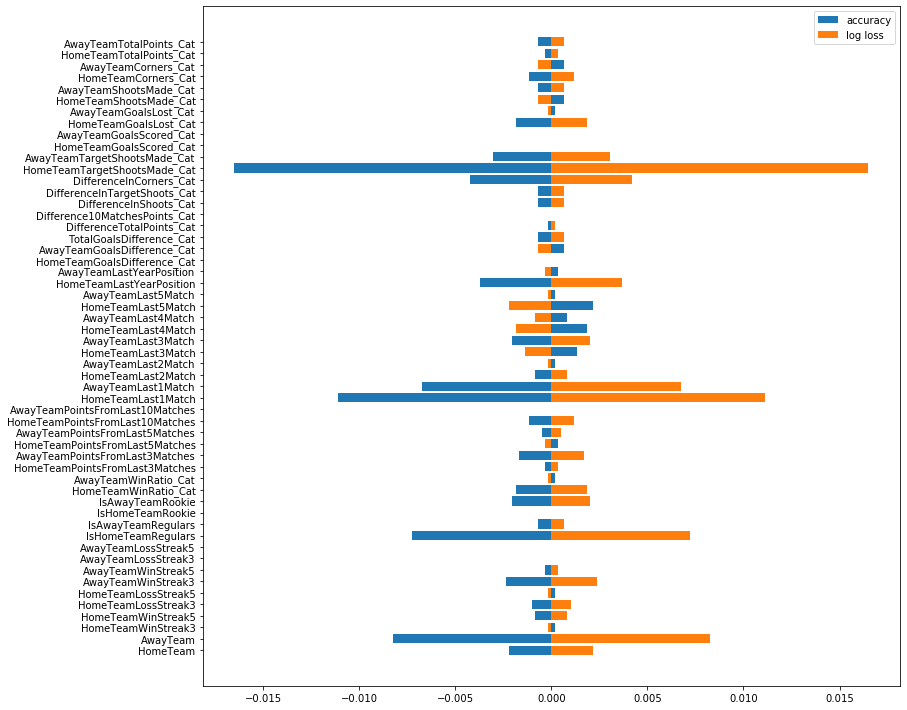

In [45]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.2.3.5 Compare accuracy for model fitting on whole and reduced dataset

In [46]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

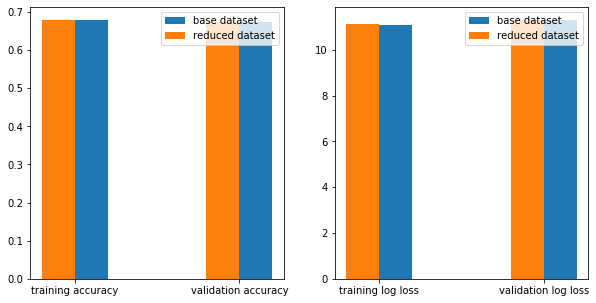

In [47]:
# fit new model on reduced dataset
clf = SVC(kernel='linear', C=0.1, probability=True, random_state=42, verbose=0)
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.2.3.6 Save reduced dataset

In [48]:
# concat reduced feature sets with labels
train_set_svc = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_svc = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_svc = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_svc.to_csv("./preprocessed_data/processed_train_set_linearsvc.csv")
valid_set_svc.to_csv("./preprocessed_data/processed_validation_set_linearsvc.csv")
test_set_svc.to_csv("./preprocessed_data/processed_test_set_linearsvc.csv")

### 4.2.4 Perform features selection for LogisticRegression model using perturbation technique

#### 4.2.4.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [49]:
clf = LogisticRegression(random_state=42, C=0.1, max_iter=1000, verbose=0)
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for LogisticRegression
Accuracy score on train set: 0.68
Accuracy score on valid set: 0.66
Base log loss result on train set: 11.22
Base log loss result on valid set: 11.62


#### 4.2.4.2 Check feature importance for this model

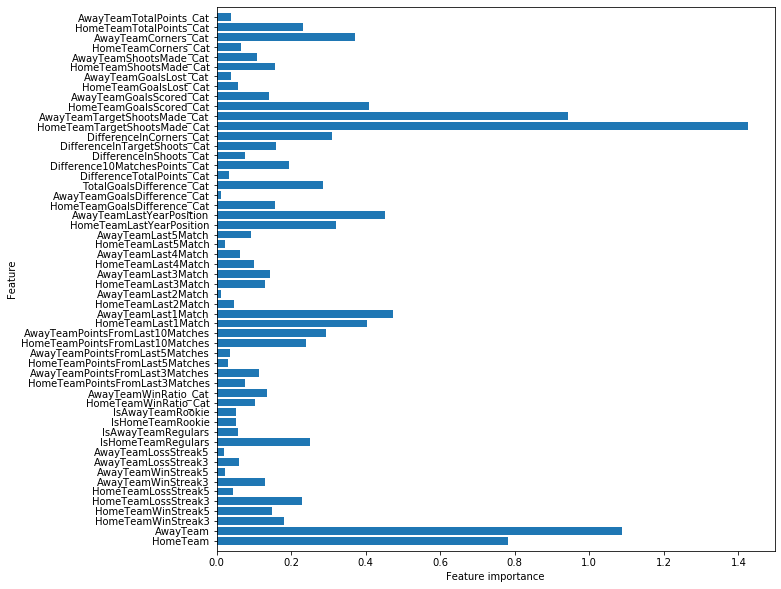

Number of features before reduction: 54


In [50]:
plt.figure(figsize=(10, 10))
plot_feature_importances(clf, X_train.columns)
plt.show()
print('Number of features before reduction:', len(X_train.columns))

#### 4.2.4.3 Reduce number of features using perturbation technique

In [51]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamLossStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsHomeTeamRookie', 'IsAwayTeamRookie', 'HomeTeamWinRatio_Cat', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'HomeTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference_Cat', 'AwayTeamGoalsDifference_Cat', 'DifferenceTotalPoints_Cat', 'Difference10MatchesPoints_Cat', 'DifferenceInTargetShoots_Cat', 'DifferenceInCorners_Cat', 'HomeTeamTargetShootsMade_Cat', 'AwayTeamTargetShootsMade_Cat', 'HomeTeamGoalsScored_Cat', 'AwayTeamGoalsScored_Cat', 'HomeTeamGoalsLost_Cat', 'AwayTeamGoalsLost_Cat', 'HomeTeamCorners_Cat', 'AwayTeamCorners_Cat', 'HomeTeamTotalPoints_Cat']
Number of features after reduction: 37


#### 4.2.4.4 Show difference in accuracy and log loss after shuffling each features

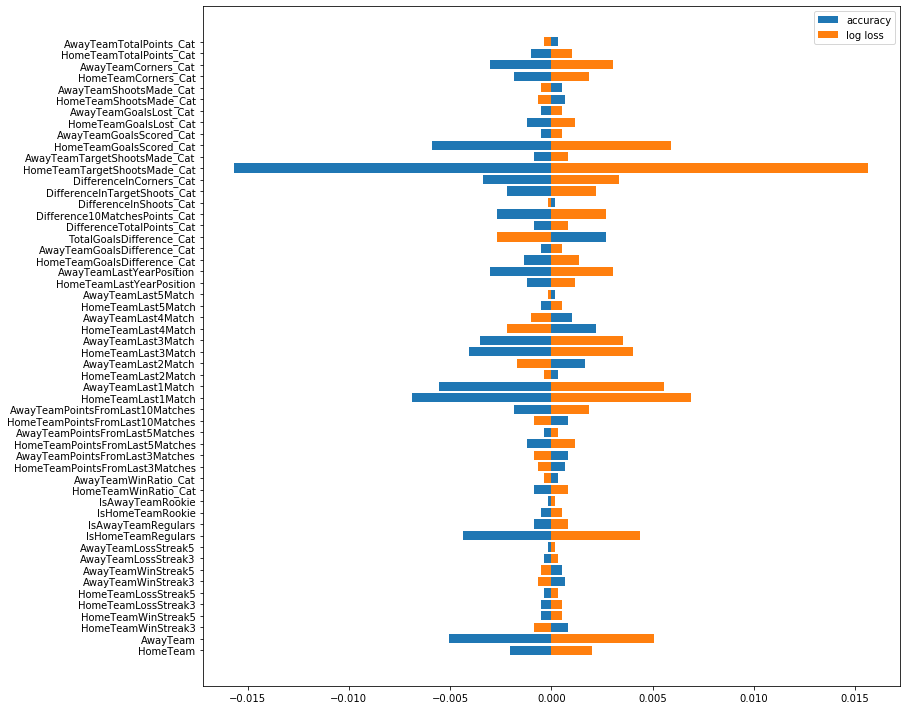

In [52]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.2.4.5 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [53]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

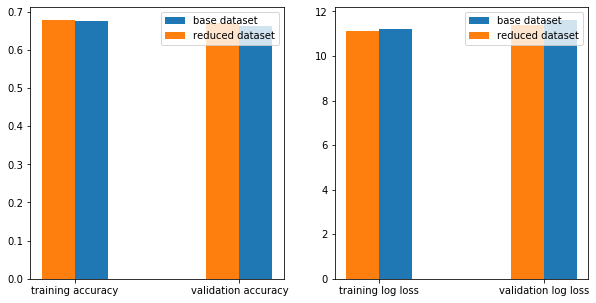

In [54]:
# fit new model on reduced dataset
clf = LogisticRegression(random_state=42, C=0.1, max_iter=1000, verbose=0)
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.2.4.6 Save reduced dataset

In [55]:
# concat reduced feature sets with labels
train_set_lr = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_lr = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_lr = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_lr.to_csv("./preprocessed_data/processed_train_set_lr.csv")
valid_set_lr.to_csv("./preprocessed_data/processed_validation_set_lr.csv")
test_set_lr.to_csv("./preprocessed_data/processed_test_set_lr.csv")

### 4.2.5 Perform features selection for KNeighborsClassifier model using perturbation technique

#### 4.2.5.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [56]:
clf = KNeighborsClassifier(n_neighbors=9, metric='manhattan', leaf_size=35)
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for KNeighborsClassifier
Accuracy score on train set: 0.72
Accuracy score on valid set: 0.66
Base log loss result on train set: 9.58
Base log loss result on valid set: 11.72


#### 4.2.5.2 Reduce number of features using perturbation technique

In [57]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamLossStreak3', 'AwayTeamWinStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRookie', 'HomeTeamWinRatio_Cat', 'HomeTeamPointsFromLast3Matches', 'HomeTeamPointsFromLast5Matches', 'AwayTeamPointsFromLast5Matches', 'HomeTeamPointsFromLast10Matches', 'AwayTeamPointsFromLast10Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'AwayTeamLast3Match', 'HomeTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'HomeTeamLastYearPosition', 'AwayTeamLastYearPosition', 'AwayTeamGoalsDifference_Cat', 'TotalGoalsDifference_Cat', 'DifferenceTotalPoints_Cat', 'Difference10MatchesPoints_Cat', 'DifferenceInShoots_Cat', 'HomeTeamTargetShootsMade_Cat', 'AwayTeamTargetShootsMade_Cat', 'HomeTeamGoalsScored_Cat', 'AwayTeamGoalsScored_Cat', 'HomeTeamGoalsLost_Cat', 'AwayTeamGoalsLost_Cat', 'HomeTeamShootsMade_Cat', 'AwayTeamShootsMade_Cat', 'HomeTeamCorners_Cat', 'AwayTeamCorners_Cat', 'HomeTeamTotalPoints_Cat

#### 4.2.5.3 Show difference in accuracy and log loss after shuffling each features

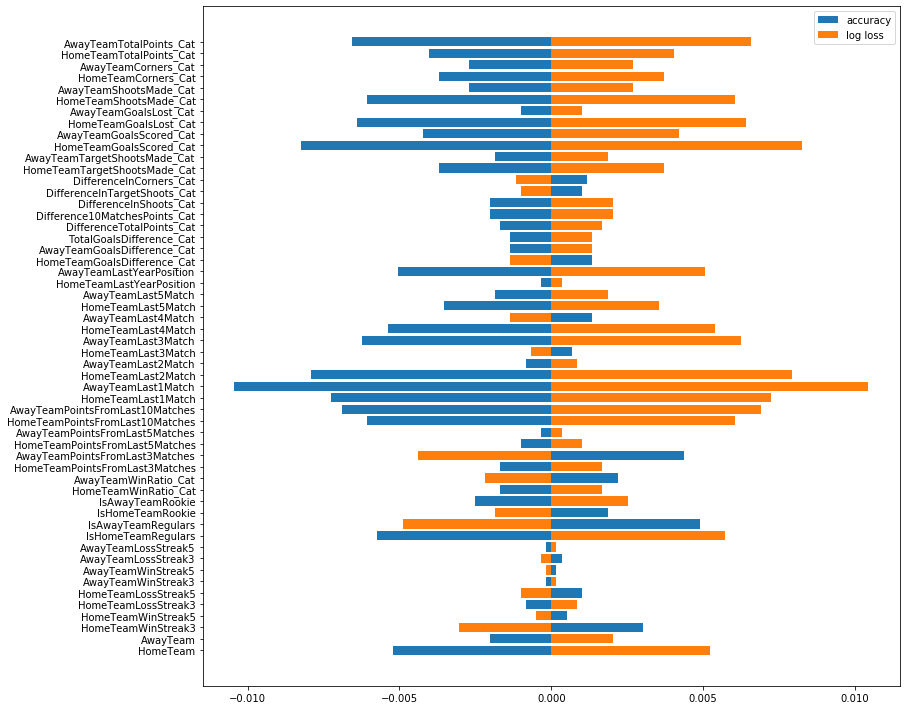

In [58]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.2.5.4 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [59]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

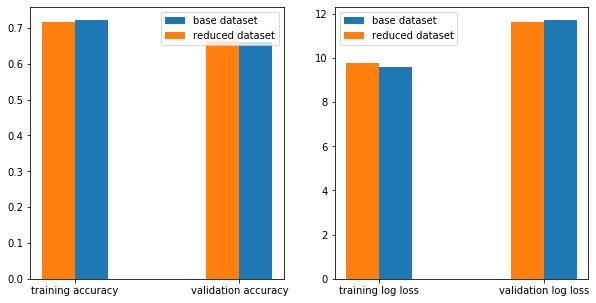

In [60]:
# fit new model on reduced dataset
clf = KNeighborsClassifier(n_neighbors=9, metric='manhattan', leaf_size=35)
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.2.5.5 Save reduced dataset

In [61]:
# concat reduced feature sets with labels
train_set_knn = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_knn = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_knn = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_knn.to_csv("./preprocessed_data/processed_train_set_knn.csv")
valid_set_knn.to_csv("./preprocessed_data/processed_validation_set_knn.csv")
test_set_knn.to_csv("./preprocessed_data/processed_test_set_knn.csv")

### 4.2.6 Perform features selection for SVC model with rbf kernel using perturbation technique

#### 4.2.6.1 Fit simple classifier on train set and check accuracy score on train and valid set

In [63]:
clf = SVC(kernel='rbf', gamma=0.01, C=100, probability=True, max_iter=1000000, random_state=42)
clf.fit(X_train, y_train)

base_acc_train = accuracy_score(y_train, clf.predict(X_train))
base_acc_valid = accuracy_score(y_valid, clf.predict(X_valid))
base_log_loss_train = log_loss(y_train, clf.predict(X_train))
base_log_loss_valid = log_loss(y_valid, clf.predict(X_valid))

print(f'Base test for {clf.__class__.__name__}')
print(f'Accuracy score on train set: {base_acc_train.round(2)}')
print(f'Accuracy score on valid set: {base_acc_valid.round(2)}')
print(f'Base log loss result on train set: {base_log_loss_train.round(2)}')
print(f'Base log loss result on valid set: {base_log_loss_valid.round(2)}')

Base test for SVC
Accuracy score on train set: 0.71
Accuracy score on valid set: 0.67
Base log loss result on train set: 10.03
Base log loss result on valid set: 11.51


#### 4.2.6.2 Reduce number of features using perturbation technique

In [64]:
# function from helpers.py, return 3 numpy arrays
best_features_idx, diff_acc_results, diff_log_loss_results = feature_reduction(clf, X_train, y_train, base_acc_train, 
                                                                               base_log_loss_train)
# show best features
print(list(X_train.columns[best_features_idx]))
print('Number of features after reduction:', len(best_features_idx))

['HomeTeam', 'AwayTeam', 'HomeTeamWinStreak3', 'HomeTeamWinStreak5', 'HomeTeamLossStreak3', 'HomeTeamLossStreak5', 'AwayTeamWinStreak3', 'AwayTeamLossStreak3', 'AwayTeamLossStreak5', 'IsHomeTeamRegulars', 'IsAwayTeamRegulars', 'IsAwayTeamRookie', 'HomeTeamWinRatio_Cat', 'HomeTeamPointsFromLast3Matches', 'HomeTeamLast1Match', 'AwayTeamLast1Match', 'HomeTeamLast2Match', 'AwayTeamLast2Match', 'HomeTeamLast3Match', 'AwayTeamLast3Match', 'AwayTeamLast4Match', 'HomeTeamLast5Match', 'AwayTeamLast5Match', 'AwayTeamLastYearPosition', 'HomeTeamGoalsDifference_Cat', 'AwayTeamGoalsDifference_Cat', 'DifferenceTotalPoints_Cat', 'HomeTeamTargetShootsMade_Cat', 'AwayTeamTargetShootsMade_Cat', 'HomeTeamGoalsScored_Cat', 'HomeTeamGoalsLost_Cat', 'HomeTeamShootsMade_Cat', 'AwayTeamShootsMade_Cat', 'AwayTeamCorners_Cat']
Number of features after reduction: 34


#### 4.2.6.3 Show difference in accuracy and log loss after shuffling each features

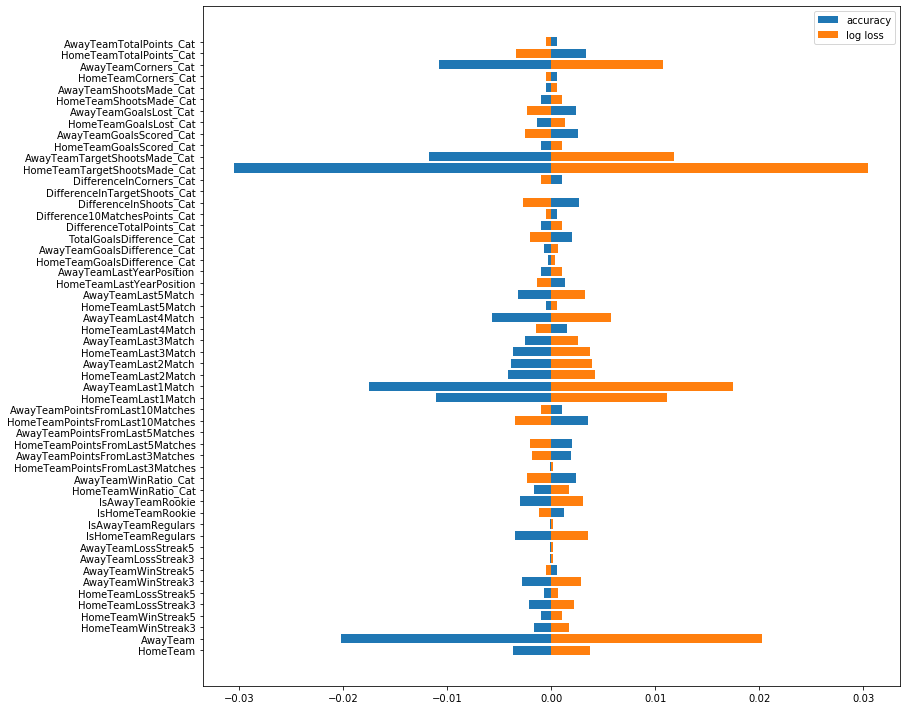

In [65]:
# transform diff_acc_results and diff_log_loss_results to the same scale
# calculate scaling ratio
ratio = np.max( np.abs(diff_acc_results) ) / np.max(np.abs( diff_log_loss_results) )

# plot differences
plt.figure(figsize=(12.5,12.5))
plt.barh(X_train.columns, diff_acc_results, label='accuracy')
plt.barh(X_train.columns, diff_log_loss_results*ratio, label='log loss')
plt.legend()
plt.show()

Function <b> feature_reduction() </b> remain features for which after shuffle log_loss difference is grather than 0 and accuracy difference is smaller than 0

#### 4.2.6.4 Compare accuracy and log loss for model fitting on whole and reduced data sets

In [66]:
# create reduced datasets
X_train_red = X_train.iloc[:,best_features_idx]
X_valid_red = X_valid.iloc[:, best_features_idx]
X_test_red = X_test.iloc[:, best_features_idx]

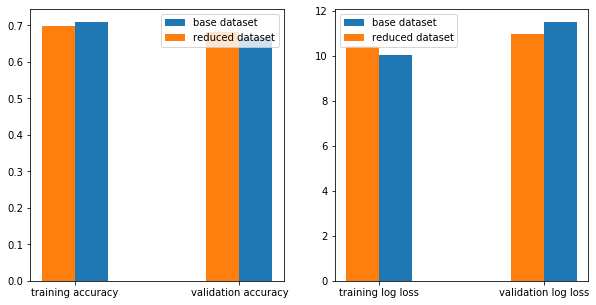

In [67]:
# fit new model on reduced dataset
clf = SVC(kernel='rbf', gamma=0.01, C=100, probability=True, max_iter=1000000, random_state=42)
clf.fit(X_train_red, y_train)

# caclulate new metrics
reduced_acc_train = accuracy_score(y_train, clf.predict(X_train_red))
reduced_acc_valid = accuracy_score(y_valid, clf.predict(X_valid_red))
reduced_log_loss_train = log_loss(y_train, clf.predict(X_train_red))
reduced_log_loss_valid = log_loss(y_valid, clf.predict(X_valid_red))

# create lists of result and labels as argumets to charts
labels_acc = ['training accuracy', 'validation accuracy']
labels_log_loss = ['training log loss', 'validation log loss']
base_dataset_acc = [base_acc_train, base_acc_valid]
base_dataset_log_loss = [base_log_loss_train, base_log_loss_valid]
reduced_dataset_acc = [reduced_acc_train, reduced_acc_valid]
reduced_dataset_log_loss = [reduced_log_loss_train, reduced_log_loss_valid]

# create subplot and show results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.bar(labels_acc, base_dataset_acc, label='base dataset', width=0.2, align='edge')
ax1.bar(labels_acc, reduced_dataset_acc, label='reduced dataset', width=-0.2, align='edge')
ax1.legend()

ax2.bar(labels_log_loss, base_dataset_log_loss, label='base dataset', width=0.2, align='edge')
ax2.bar(labels_log_loss, reduced_dataset_log_loss, label='reduced dataset', width=-0.2, align='edge')
ax2.legend()
plt.show()

#### 4.2.6.5 Save reduced dataset

In [68]:
# concat reduced feature sets with labels
train_set_rbf = pd.concat([X_train_red, y_train], axis=1, sort=False)
valid_set_rbf = pd.concat([X_valid_red, y_valid], axis=1, sort=False)
test_set_rbf = pd.concat([X_test_red, y_test], axis=1, sort=False)

train_set_rbf.to_csv("./preprocessed_data/processed_train_set_svc_rbf.csv")
valid_set_rbf.to_csv("./preprocessed_data/processed_validation_set_svc_rbf.csv")
test_set_rbf.to_csv("./preprocessed_data/processed_test_set_svc_rbf.csv")